# Installation and Repository cloning

In [ ]:
!pip install adversarial-robustness-toolbox -U
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install matplotlib
!pip install pillow
!pip install foolbox

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
import json
import foolbox as fb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [3]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare Adversarial Model

In [4]:
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

net.eval()
net.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART toolbox as a wrapper
art_net = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10,
                               device_type=device,
                               clip_values=(0.0, 1.0))
fb_net = fb.PyTorchModel(net, bounds=(0.0, 1.0), device=device)

/home/shao/anaconda3/envs/art/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/shao/anaconda3/envs/art/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/shao/anaconda3/envs/art/lib/python3.12/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/shao/anaconda3/envs/art/lib/python3.12/site-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with 

## Function to Test Model Accuracy

In [5]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

## Adversarial Attacks

In [6]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentPyTorch,
                                 AutoProjectedGradientDescent,
                                 AutoAttack,
                                 CarliniL2Method,
                                 DeepFool,
                                 ElasticNet)
from autoattack import AutoAttack as original_AutoAttack

In [7]:
class AdversarialAttacks:
  def __init__(self, art_net, net, epsilon, eps_iter, norm, max_iterations_fast_attacks, max_iterations_slow_attacks):
    self.art_net = art_net
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.max_iterations_fast_attacks = max_iterations_fast_attacks
    self.max_iterations_slow_attacks = max_iterations_slow_attacks
    self.net = net

  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.art_net,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.max_iterations_fast_attacks,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='ART_AutoAttack':
        return AutoAttack(estimator=self.art_net,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='original_AutoAttack':
        return original_AutoAttack(net, 
                                   norm='L1', 
                                   eps=epsilon,
                                   device=device)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.art_net,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.max_iterations_fast_attacks,
                                          **kwargs)
    elif attack_type=='brendel_bethge':
        return fb.attacks.L1BrendelBethgeAttack(steps=self.max_iterations_fast_attacks)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.art_net,
                               max_iter=self.max_iterations_slow_attacks,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.art_net,
                      max_iter=self.max_iterations_fast_attacks,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks)
    elif attack_type=='elastic_net_L1_rule':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1')
    elif attack_type=='elastic_net_L1_rule_higher_beta':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1',
                      beta=0.01)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [8]:
def attack_with_early_stopping(art_net, x, y, PGD_iterations, attacker):
    label_flipped = False

    for j in range(PGD_iterations):
        adv_inputs = attacker.generate(x, y.numpy(), verbose=False)

        outputs = art_net.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).data, 1)
        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
        
        x = adv_inputs.copy()
            
    return adv_inputs

## Function for Adversarial Distance calculation (attack methods)

In [24]:
def calculation(art_net, fb_net, net, xtest, ytest, epsilon, eps_iter, norm, max_iterations_slow_attacks, max_iterations_fast_attacks, attack_type, verbose: bool = False):

    distance_list, runtime_list = [], []
    art_net.model.to(device)
    net.to(device)
    
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(art_net=art_net,
                                 net = net,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          max_iterations_fast_attacks=max_iterations_fast_attacks,
                          max_iterations_slow_attacks=max_iterations_slow_attacks)
    attacker = attacks.init_attacker(attack_type)

    robust_predictions = 0
    attack_successes = 0
    clean_correct = 0

    for i, x in enumerate(xtest):

        x = x.unsqueeze(0)
        y = ytest[i].unsqueeze(0)
        outputs = art_net.predict(x.cpu())
        
        _, clean_predicted = torch.max(torch.tensor(outputs).data, 1)
            
        if int(clean_predicted.item()) != int(y.item()):
            print('Misclassified input. Not attacking.')
            distance_list.append(False)
            runtime_list.append(False)
            continue        

        clean_correct += 1

        start_time = time.time()

        if attack_type == 'pgd_early_stopping':
            x_adversarial = attack_with_early_stopping(art_net=art_net,
                                                                x=x.numpy(),
                                                                y=y,
                                                                PGD_iterations=max_iterations_fast_attacks,
                                                                attacker=attacker)
            x_adversarial = torch.from_numpy(x_adversarial)
        elif attack_type == 'brendel_bethge':
            _, x_adversarial, _ = attacker(fb_net, x, y, epsilons=[epsilon])
            x_adversarial = x_adversarial[0]
        elif attack_type == 'original_AutoAttack':
            x_adversarial = attacker.run_standard_evaluation(x, y)
            x_adversarial = x_adversarial
        else:             
            x_adversarial = attacker.generate(x.cpu().numpy(), y.cpu().numpy())
            x_adversarial = torch.from_numpy(x_adversarial)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Adversarial accuracy calculation
        output_adversarial = art_net.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).data, 1)

        # Adversarial distance calculation: if no AE found, save epsilon as distance, otherwise save the distance
        if int(predicted_adversarial.item()) == int(y.item()):
            robust_predictions += 1
            distance = epsilon
            distance_list.append(distance)
            if verbose:
                print(f'Image {i}: No adversarial example found.')
        else:
            distance = torch.norm((x.cpu() - x_adversarial), p=float(norm))
            robust_predictions += (round(distance.item(), 2) > epsilon) 
            attack_successes += (round(distance.item(), 2) <= epsilon) 
            distance_list.append(min(distance.item(), epsilon)) #appending epsilon if distance of adversarial example is higher

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')
        if (i + 1) % 20 == 0:
            print(f'{i+1} images done. Current Adversarial Accuracy: {robust_predictions/(i+1)}%')

    adversarial_accuracy = (robust_predictions / len(xtest)) * 100
    attack_success_rate = (attack_successes / clean_correct) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy, attack_success_rate

## Parameters

In [10]:
norm = 1  # 1, 2, np.inf
max_iterations_fast_attacks = 100
max_iterations_slow_attacks = 20
eps_iter = 0.15
epsilon = 12

## Load the dataset

In [11]:
splitsize = 50      # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

Files already downloaded and verified


## Test Accuracy

In [12]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 92.000%



# Experiments

In [25]:
attack_types = [#'fast_gradient_method', #bounded-full
                #'projected_gradient_descent', #bounded-full
                #'pgd_early_stopping', #not-bounded
                #'auto_projected_gradient_descent', #bounded-full
                #'deep_fool', #not-bounded
                #'brendel_bethge', #bounded-min
                #'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                #'elastic_net_L1_rule', #not-bounded
                #'elastic_net_L1_rule_higher_beta', #not-bounded
                #'ART_AutoAttack', #bounded-full
                #'original_AutoAttack', #bounded-full
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] , results_dict[attack_type]["attack_success_rate"] = calculation(
                                                        art_net=art_net,
                                                        fb_net=fb_net,
                                                        net = net,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations_fast_attacks=max_iterations_fast_attacks,
                                                        max_iterations_slow_attacks=max_iterations_slow_attacks,
                                                        attack_type=attack_type,
                                                        verbose=True)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: elastic_net --------------------------



EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 0		Adversarial_distance: 18.75915		Runtime: 2.622064 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 1		Adversarial_distance: 45.86557		Runtime: 2.381144 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 2		Adversarial_distance: 40.57151		Runtime: 2.054041 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 3		Adversarial_distance: 16.51984		Runtime: 2.051484 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 4		Adversarial_distance: 0.40278		Runtime: 2.162477 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 5		Adversarial_distance: 28.52516		Runtime: 2.376546 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 6		Adversarial_distance: 30.74511		Runtime: 2.254598 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 7		Adversarial_distance: 42.81296		Runtime: 2.257864 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 8		Adversarial_distance: 12.69096		Runtime: 2.304223 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 9		Adversarial_distance: 9.78339		Runtime: 2.308044 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 10		Adversarial_distance: 115.99493		Runtime: 3.005479 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 11		Adversarial_distance: 22.00362		Runtime: 2.164811 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 12		Adversarial_distance: 26.18356		Runtime: 2.253181 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 13		Adversarial_distance: 14.89736		Runtime: 2.359621 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 14		Adversarial_distance: 9.49823		Runtime: 2.188914 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 15		Adversarial_distance: 21.44664		Runtime: 2.307541 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 16		Adversarial_distance: 1.09927		Runtime: 2.195010 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 17		Adversarial_distance: 84.36816		Runtime: 2.178411 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 18		Adversarial_distance: 18.17315		Runtime: 2.158727 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 19		Adversarial_distance: 77.87128		Runtime: 2.177630 seconds
20 images done. Current Adversarial Accuracy: 0.8%


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 20		Adversarial_distance: 86.28923		Runtime: 2.128941 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 21		Adversarial_distance: 29.94107		Runtime: 2.182299 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 22		Adversarial_distance: 31.70476		Runtime: 2.187339 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 23		Adversarial_distance: 52.42795		Runtime: 2.192708 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 24		Adversarial_distance: 20.80748		Runtime: 2.410914 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 25		Adversarial_distance: 50.68554		Runtime: 2.994704 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 26		Adversarial_distance: 36.71457		Runtime: 2.217596 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 27		Adversarial_distance: 73.96265		Runtime: 2.140302 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 28		Adversarial_distance: 24.97935		Runtime: 2.234634 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 29		Adversarial_distance: 21.45646		Runtime: 2.363768 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 30		Adversarial_distance: 62.14001		Runtime: 2.270633 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 31		Adversarial_distance: 22.07111		Runtime: 2.219188 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 33		Adversarial_distance: 49.52401		Runtime: 2.241055 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 34		Adversarial_distance: 40.98625		Runtime: 2.236621 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 36		Adversarial_distance: 57.91250		Runtime: 2.266838 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 37		Adversarial_distance: 74.54562		Runtime: 2.206154 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 38		Adversarial_distance: 1.51644		Runtime: 2.191310 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 40		Adversarial_distance: 19.44526		Runtime: 2.175874 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 41		Adversarial_distance: 19.44192		Runtime: 2.224828 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 42		Adversarial_distance: 5.04204		Runtime: 2.698885 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 43		Adversarial_distance: 65.47874		Runtime: 2.221364 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 44		Adversarial_distance: 12.38005		Runtime: 2.216036 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 46		Adversarial_distance: 31.68126		Runtime: 2.222466 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 47		Adversarial_distance: 28.10501		Runtime: 2.184603 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 48		Adversarial_distance: 36.61040		Runtime: 2.209860 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 49		Adversarial_distance: 39.52797		Runtime: 2.167418 seconds

Adversarial accuracy: 80.0%


Mean adversarial distance for elastic_net: 10.14684 with total runtime:  104.76815 seconds



## Save Results to JSON File

In [26]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

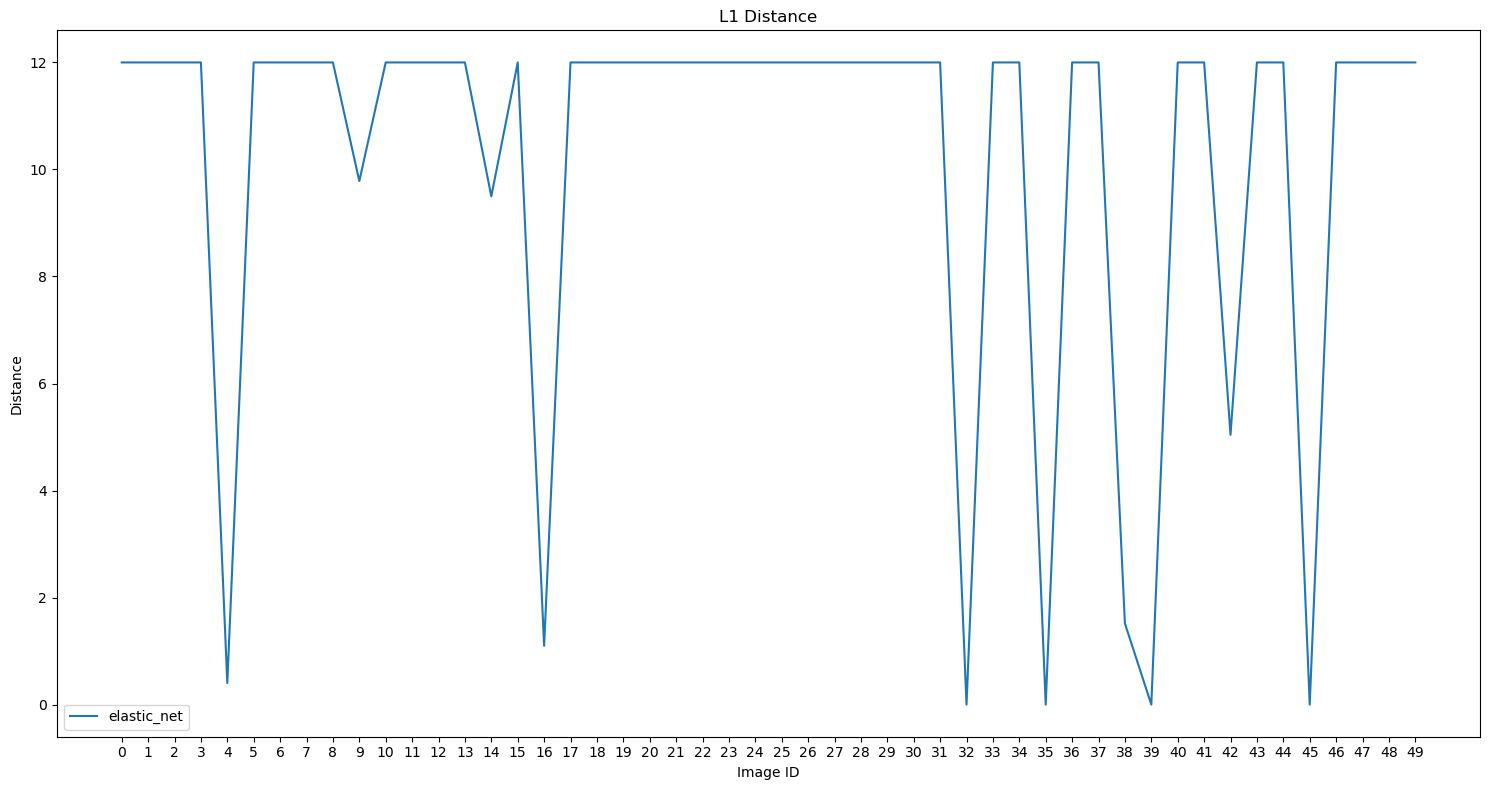

In [27]:
attack_types_with_distance = [
                'brendel_bethge', #bounded-min
                'pgd_early_stopping', #not-bounded
                'deep_fool', #not-bounded
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                ]

selected_attack_types_with_distance = [a for a in attack_types if a in attack_types_with_distance]

plt.figure(figsize=(15, 8))
for attack_type in selected_attack_types_with_distance:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Runtime per image')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['attack_success_rate'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Attack Success Rate [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Attack Success Rate')
plt.tight_layout()
plt.show()

## Total Runtime

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime'])/splitsize, label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Average Runtime per Image')
plt.legend()
plt.tight_layout()
plt.show()